In [2]:
import numpy as np
import matplotlib.pyplot as plt
import itertools

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import learning_curve
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_auc_score,accuracy_score, precision_score,recall_score


from keras.datasets import cifar10

import warnings
warnings.filterwarnings('ignore')

60000 images total. We have 10,000 testing images and 50,000 images for training. We further split the 50,000 images into 40,000 images for training and 10,000 images for validation

In [3]:
(X_tr, y_tr), (X_te, y_te) = cifar10.load_data()
seed = 1234 # for reproduction
# Concatenate train and test images
X = np.concatenate((X_tr,X_te))
y = np.concatenate((y_tr,y_te))
# Randomization
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=10000, random_state=seed,shuffle=True)
# size of X_tr = (50000,32,32,3) where (32,32) is size of the image and (3) is red,green,and blue channel values.
# we have 50000 datapoints for training set, and each set will have 32*32*3 = 3072 features. we need to reshape for training 
X_tr = X_tr.reshape(50000,3072)
X_te = X_te.reshape(10000,3072)
y_tr = y_tr.reshape(50000)
y_te = y_te.reshape(10000)

#X_tr_lc is training set with 50000 datapoints for model.selection.learning_curve
X_tr_lc = X_tr
y_tr_lc = y_tr


In [4]:
# Validation sets
X_val = X_tr[40000:50000]
y_val = y_tr[40000:50000]
# Training sets
X_tr = X_tr[:40000]
y_tr = y_tr[:40000]
print(X_tr.shape)
print(y_tr.shape)

(40000, 3072)
(40000,)


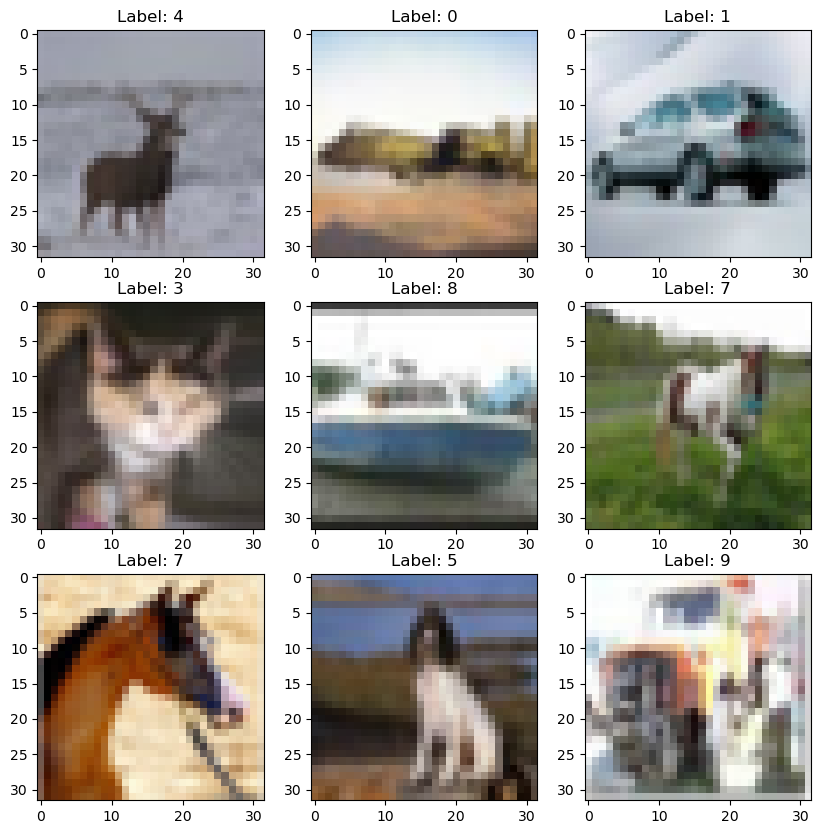

In [15]:
fig, axes = plt.subplots(3, 3, figsize=(10, 10)) 

for i in range(9):
    img = X_tr[i]
    axes[i//3, i%3].imshow(img.reshape(32,32,3)) # to show the image, we have to convert 3072 features back to (32,32,3)
    label = y_tr[i] 
    axes[i//3, i%3].set_title(f'Label: {label}') 

In [5]:
# Reshape fit and transform the data for better results
scaler = StandardScaler()
X_tr = scaler.fit_transform(X_tr)
X_te = scaler.transform(X_te)
X_val = scaler.transform(X_val)
X_tr_lc = scaler.transform(X_tr_lc)
#Take smaller size of training set for better runtime
#X_tr = X_tr[:5000]
#y_tr = y_tr[:5000]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


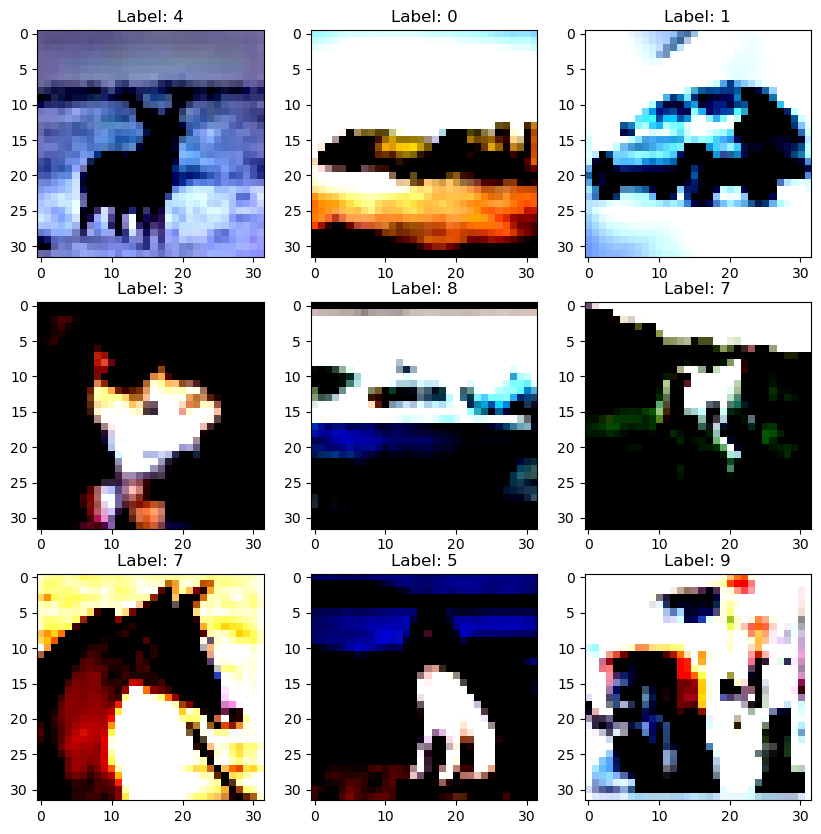

In [17]:
#plot scaled images
fig, axes = plt.subplots(3, 3, figsize=(10, 10)) 

for i in range(9):
    img = X_tr[i]
    axes[i//3, i%3].imshow(img.reshape(32,32,3)) # to show the image, we have to convert 3072 features back to (32,32,3)
    label = y_tr[i] 
    axes[i//3, i%3].set_title(f'Label: {label}') 

1. KNN Classifier

k equals to:  3
Accuracy on validation set: 0.31440
roc_auc_score on validation set: 0.69593
Accuracy on testing set: 0.31870
roc_auc_score on testing set: 0.69747
k equals to:  5
Accuracy on validation set: 0.32360
roc_auc_score on validation set: 0.72370
Accuracy on testing set: 0.33350
roc_auc_score on testing set: 0.72621
k equals to:  7
Accuracy on validation set: 0.32600
roc_auc_score on validation set: 0.73759
Accuracy on testing set: 0.33260
roc_auc_score on testing set: 0.74307
k equals to:  8
Accuracy on validation set: 0.32420
roc_auc_score on validation set: 0.74377
Accuracy on testing set: 0.33560
roc_auc_score on testing set: 0.74830
k equals to:  9
Accuracy on validation set: 0.32260
roc_auc_score on validation set: 0.74883
Accuracy on testing set: 0.33500
roc_auc_score on testing set: 0.75450
k equals to:  10
Accuracy on validation set: 0.32040
roc_auc_score on validation set: 0.75357
Accuracy on testing set: 0.33540
roc_auc_score on testing set: 0.75735
k equals to:  1

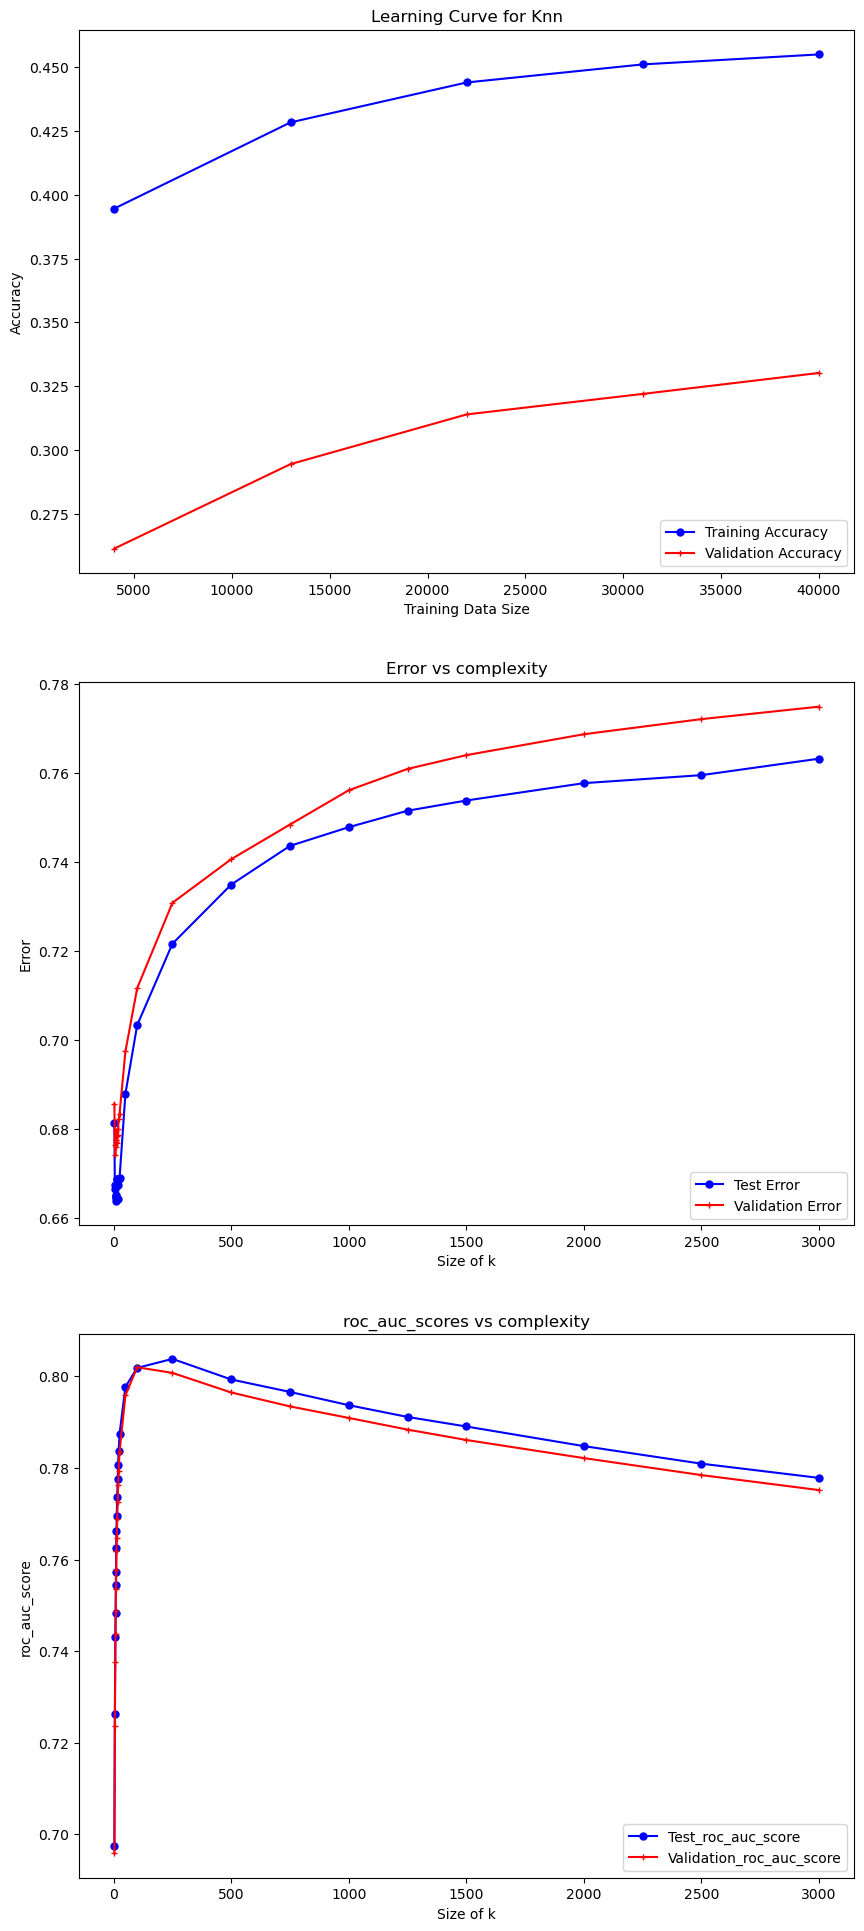

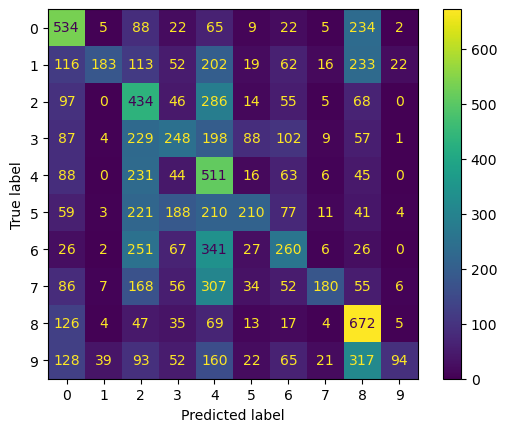

In [19]:
#KNN

fig, axes = plt.subplots(3,1,figsize=(10, 24))

val_error_list = []
te_error_list = []
val_roc_auc_score_list =[]
te_roc_auc_score_list =[]

max_accuracy_index = 0
max_accuracy = 0
best_k_test_accuracy = 0
i = 0
#different hyper parameters
k_list = [3,5,7,8,9,10,11,12,13,15,17,19,21,25,50,100,250,500,750,1000,1250,1500,2000,2500,3000]
for k in k_list:
    print("===============================================")
    print("k equals to: ", k)
    knn = KNeighborsClassifier(n_neighbors=k).fit(X_tr, y_tr)
    # Accuracy/error, ROC AUC score on validation set and testing set
    y_val_scores = knn.predict_proba(X_val)
    y_te_scores = knn.predict_proba(X_te)

    val_accuracy = knn.score(X_val,y_val)
    val_error = 1 - val_accuracy
    val_roc_auc_score = roc_auc_score(y_val,y_val_scores, average='macro',multi_class='ovr')

    te_accuracy = knn.score(X_te,y_te)
    te_error = 1-te_accuracy
    te_roc_auc_score = roc_auc_score(y_te,y_te_scores, average='macro',multi_class='ovr')
    #val_precision = precision_score(y_val, y_val_pred,average='macro')
    #val_recall = recall_score(y_val, y_val_pred,average='macro')
    print('Accuracy on validation set: %.5f' % val_accuracy)
    print('roc_auc_score on validation set: %.5f'% val_roc_auc_score)
    print('Accuracy on testing set: %.5f' % te_accuracy)
    print('roc_auc_score on testing set: %.5f'% te_roc_auc_score)
    val_error_list.append(val_error)
    te_error_list.append(te_error)
    val_roc_auc_score_list.append(val_roc_auc_score)
    te_roc_auc_score_list.append(te_roc_auc_score)
    #determine the best k's index 
    if i == 0:
        max_accuracy = val_accuracy
        best_k_test_accuracy = te_accuracy
    else:
        if(max_accuracy<val_accuracy):
            max_accuracy = val_accuracy
            max_accuracy_index = i
            best_k_test_accuracy = te_accuracy
    i+=1
#end for

best_k = k_list[max_accuracy_index]
print("===============================================")
print("best k is:", best_k,"accuracy on testing set is ", best_k_test_accuracy)
knn = KNeighborsClassifier(n_neighbors=best_k).fit(X_tr, y_tr)
#Learning Curve
train_sizes, train_scores, test_scores = learning_curve(estimator=knn, X=X_tr_lc, y=y_tr_lc,n_jobs=1)
train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
axes[0].plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Training Accuracy')
axes[0].plot(train_sizes, test_mean, color='red', marker='+', markersize=5, label='Validation Accuracy')
axes[0].set_title('Learning Curve for Knn')
axes[0].set_xlabel('Training Data Size')
axes[0].set_ylabel('Accuracy')
axes[0].legend(loc='lower right')
#Error vs complexity tradeoffs
axes[1].plot(k_list, te_error_list, color='blue', marker='o', markersize=5, label='Test Error')
axes[1].plot(k_list, val_error_list, color='red', marker='+', markersize=5, label='Validation Error')
axes[1].set_title('Error vs complexity')
axes[1].set_xlabel('Size of k')
axes[1].set_ylabel('Error')
axes[1].legend(loc='lower right')
#roc_auc_scores vs complexity
axes[2].plot(k_list, te_roc_auc_score_list, color='blue', marker='o', markersize=5, label='Test_roc_auc_score')
axes[2].plot(k_list, val_roc_auc_score_list, color='red', marker='+', markersize=5, label='Validation_roc_auc_score')
axes[2].set_title('roc_auc_scores vs complexity')
axes[2].set_xlabel('Size of k')
axes[2].set_ylabel('roc_auc_score')
axes[2].legend(loc='lower right')
#Confusion Matrix for the best k
y_te_pred = knn.predict(X_te)
sklearn_cm = confusion_matrix(y_te, y_te_pred)
sklearn_disp = ConfusionMatrixDisplay(confusion_matrix = sklearn_cm)
sklearn_disp.plot()



2.Logistic Regression

In [16]:
# GRIDSEARCH FOR LOGISTIC
X_val1 = X_val[:1000]
y_val1 = y_val[:1000]
#Using GridSearch to find the best hyperparameters for logistic regression classifer
model = LogisticRegression(random_state=seed)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=seed)
parameters = dict()
# parameters['solver'] = ['newton-cg', 'lbfgs', 'liblinear']
parameters['penalty'] = ['none','l2']
parameters['C'] = [100, 10, 1.0, 0.1, 0.01]

search = GridSearchCV(model, parameters, scoring='accuracy', n_jobs=2, cv=10)
search = search.fit(X_val1,y_val1)

print('Best Score: %s' % search.best_score_)
print('Best Hyperparameters: %s' % search.best_params_)

Best Score: 0.31999999999999995
Best Hyperparameters: {'C': 0.01, 'penalty': 'l2'}


Accuracy: 0.28680
Precision: 0.28845
Recall: 0.28723
roc_auc_score: 0.72131


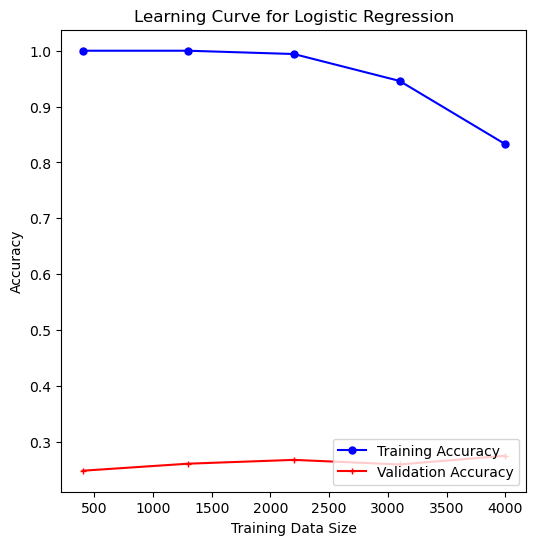

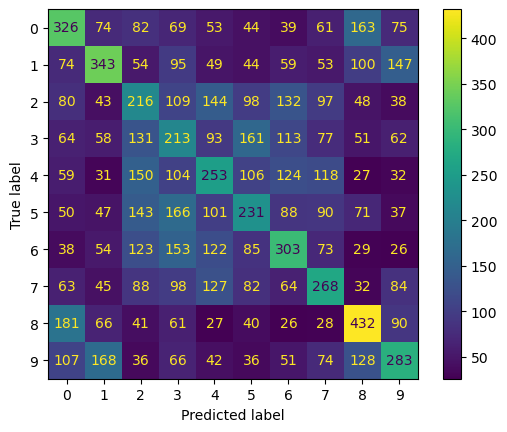

In [30]:
#Logistic Regression

fig, axes = plt.subplots(figsize=(6, 6))
lr = LogisticRegression(random_state=seed).fit(X_tr, y_tr)
#Confusion Matrix
y_te_pred = lr.predict(X_te)
sklearn_cm = confusion_matrix(y_te, y_te_pred)
sklearn_disp = ConfusionMatrixDisplay(confusion_matrix = sklearn_cm)
sklearn_disp.plot()
# Accuracy, Precision, Recall, ROC AUC score
y_te_scores = lr.predict_proba(X_te)
print('Accuracy: %.5f' % accuracy_score(y_te, y_te_pred))
print('Precision: %.5f' % precision_score(y_te, y_te_pred,average='macro'))
print('Recall: %.5f' % recall_score(y_te, y_te_pred,average='macro'))
print('roc_auc_score: %.5f'% roc_auc_score(y_te,y_te_scores, average='macro',multi_class='ovr'))

#Learning Curve
train_sizes, train_scores, test_scores = learning_curve(estimator=lr, X=X_tr, y=y_tr,n_jobs=1)
train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)

axes.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Training Accuracy')
axes.plot(train_sizes, test_mean, color='red', marker='+', markersize=5, label='Validation Accuracy')
axes.set_title('Learning Curve for Logistic Regression')
axes.set_xlabel('Training Data Size')
axes.set_ylabel('Accuracy')
axes.legend(loc='lower right')



ValueError: X has 3072 features, but PolynomialFeatures is expecting 300 features as input.

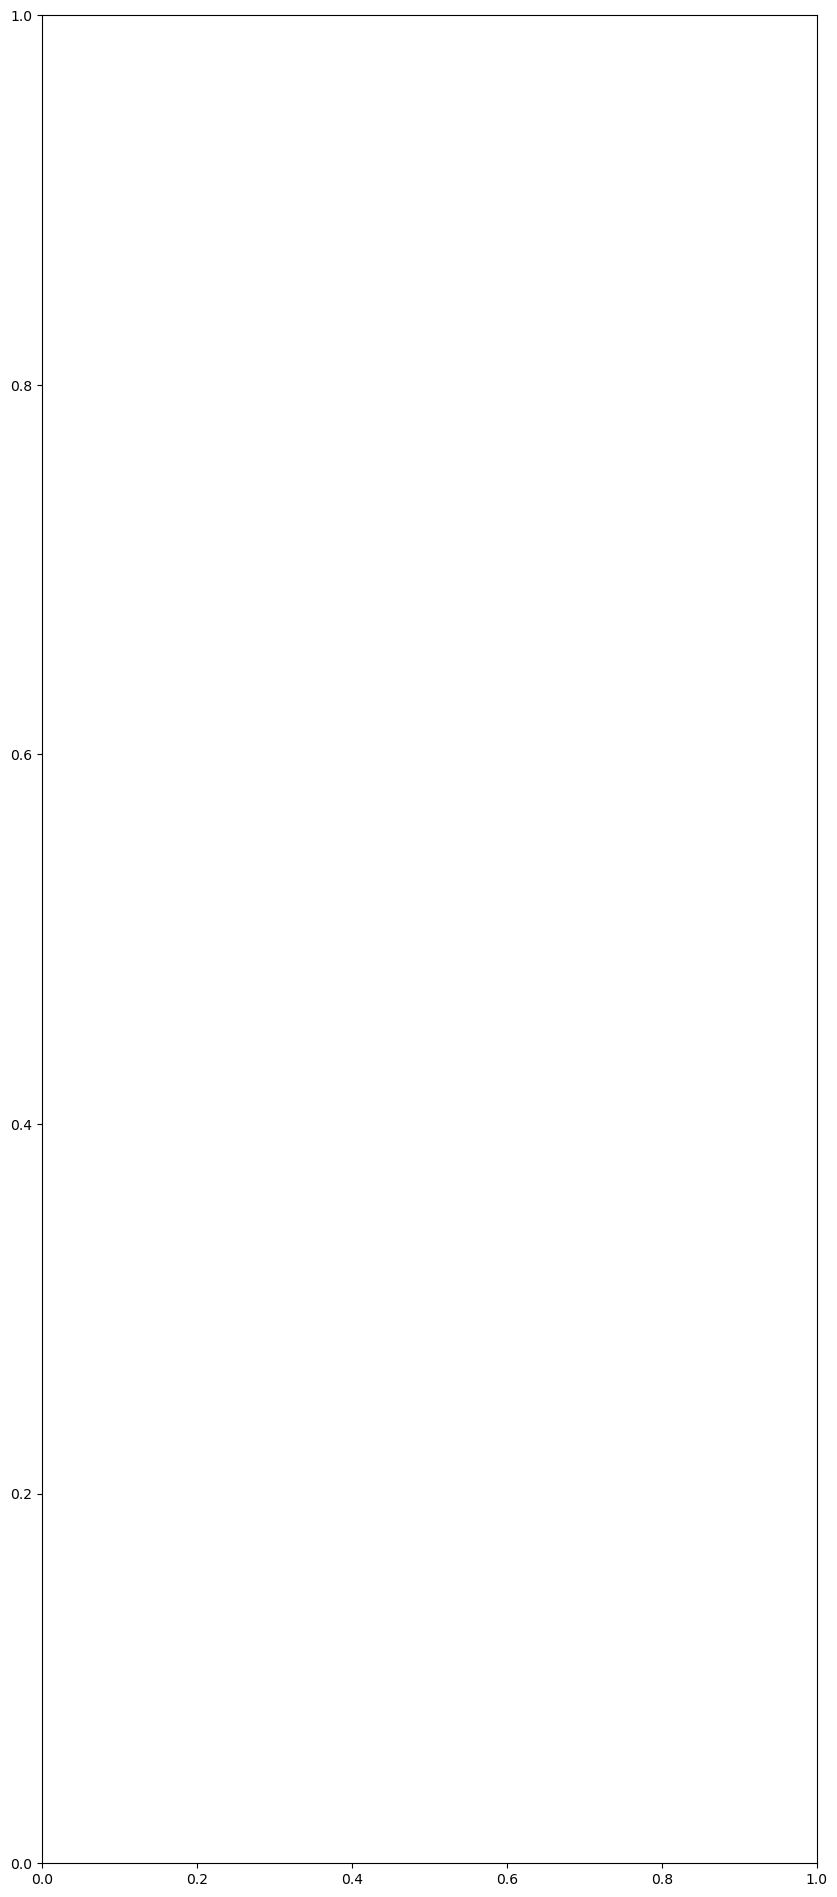

In [17]:
from sklearn.preprocessing import PolynomialFeatures
n = [1,2,3,4,5,6,7,8,9,10]
X_tr1 = X_tr[:5000]
y_tr1 = y_tr[:5000]
tr_error_list = []
te_error_list = []
fig, axes = plt.subplots(figsize=(10, 24))
for i in n:
    poly = PolynomialFeatures(degree = i, interaction_only=False, include_bias=False)
    X_poly = poly.fit_transform(X_tr1)
    lr = LogisticRegression(random_state=seed)
    lr.fit(X_poly,y_tr1)
    
    pipe = Pipeline([('polynomial_features',poly), ('logistic_regression',lr)])
    pipe.fit(X_tr1, y_tr1)
    te_error = 1-pipe.score(X_te, y_te)
    tr_error = 1-pipe.score(X_tr1, y_tr1)
    
    tr_error_list.append(tr_error)
    te_error_list.append(te_error)
    
    print(f'Score for {i} degrees: {pipe.score(X_te, y_te)}')
    
#Error vs complexity tradeoffs
axes.plot(k_list, te_error_list, color='blue', marker='o', markersize=5, label='Test Error')
axes.plot(k_list, tr_error_list, color='red', marker='+', markersize=5, label='Training Error')
axes.set_title('Error vs complexity')
axes.set_xlabel('Number of Degrees')
axes.set_ylabel('Error')
axes.legend(loc='lower right')

3.clf Neural Network

In [ ]:
# param = [
#     {'scaler': [StandardScaler()],
#      'estimator': [MLPClassifier(random_state=seed)],
#      'estimator__solver': ['adam'],
#      'estimator__learning_rate_init': [0.0001],
#      'estimator__max_iter': [100],
#      'estimator__hidden_layer_sizes': [(64,),(64,124,32),(32,64,12)],
#      'estimator__activation': ['logistic', 'tanh', 'relu'],
#      'estimator__alpha': [0.0001, 0.001, 0.005,0.1,0.01],
#      'estimator__early_stopping': [True, False]
#      }
# ]

# pipe = Pipeline([('scaler', None), ('estimator', MLPClassifier())])


# X_val1 = X_val[:1000]
# y_val1 = y_val[:1000]
# #Using GridSearch to find the best hyperparameters for logistic regression classifer
# # cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=seed)

# search = GridSearchCV(pipe, param, scoring='accuracy', n_jobs=3, cv=10)
# search = search.fit(X_val1,y_val1)

# print('Best Score: %s' % search.best_score_)
# print('Best Hyperparameters: %s' % search.best_params_)

Accuracy: 0.47160
Precision: 0.49911
Recall: 0.47278
roc_auc_score: 0.84217


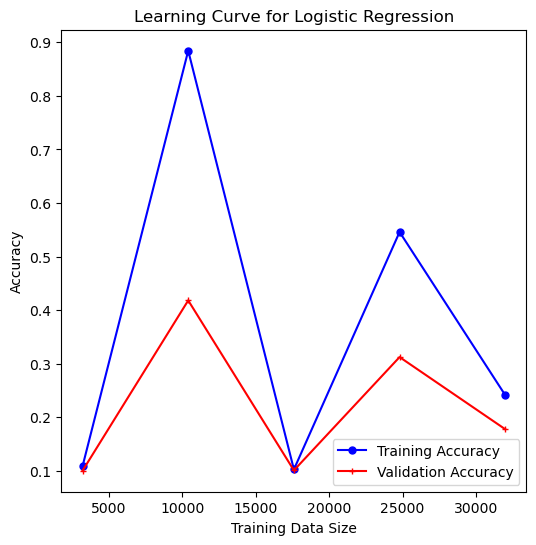

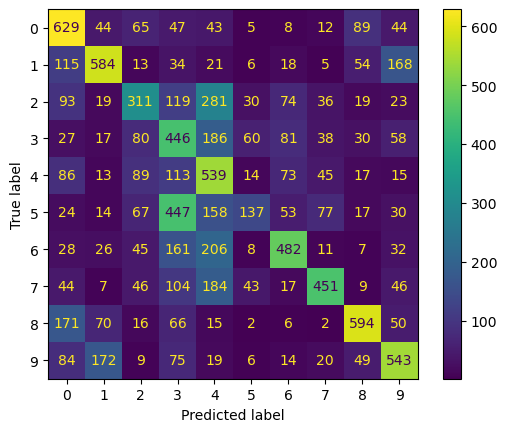

In [6]:
#clf Neural Network

fig, axes = plt.subplots(figsize=(6, 6))
clf = MLPClassifier(hidden_layer_sizes=(256,128,64,32),activation = 'relu',n_iter_no_change=100,
                    solver='adam',max_iter=100, learning_rate_init = 0.01, batch_size=256,random_state=seed).fit(X_tr, y_tr)
#Confusion Matrix
y_te_pred = clf.predict(X_te)
sklearn_cm = confusion_matrix(y_te, y_te_pred)
sklearn_disp = ConfusionMatrixDisplay(confusion_matrix = sklearn_cm)
sklearn_disp.plot()
# Accuracy, Precision, Recall, ROC AUC score
y_te_scores = clf.predict_proba(X_te)
print('Accuracy: %.5f' % accuracy_score(y_te, y_te_pred))
print('Precision: %.5f' % precision_score(y_te, y_te_pred,average='macro'))
print('Recall: %.5f' % recall_score(y_te, y_te_pred,average='macro'))
print('roc_auc_score: %.5f'% roc_auc_score(y_te,y_te_scores, average='macro',multi_class='ovr'))

#Learning Curve
train_sizes, train_scores, test_scores = learning_curve(estimator=clf, X=X_tr, y=y_tr,n_jobs=1)
train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)

axes.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Training Accuracy')
axes.plot(train_sizes, test_mean, color='red', marker='+', markersize=5, label='Validation Accuracy')
axes.set_title('Learning Curve for Neural Network')
axes.set_xlabel('Training Data Size')
axes.set_ylabel('Accuracy')
axes.legend(loc='lower right')


4.Decision tree

Accuracy: 0.22840
Precision: 0.18687
Recall: 0.22919
roc_auc_score: 0.66555


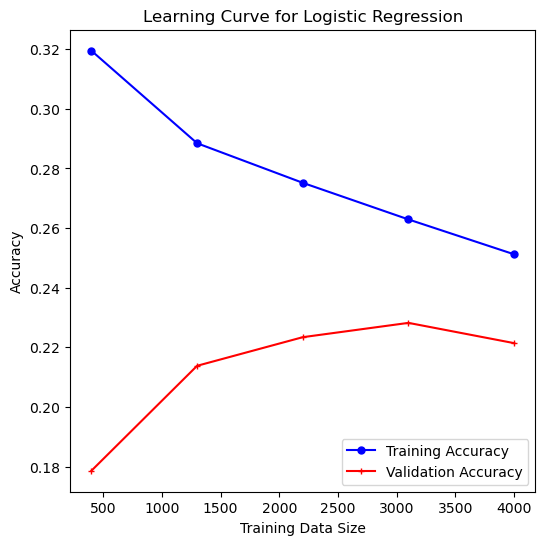

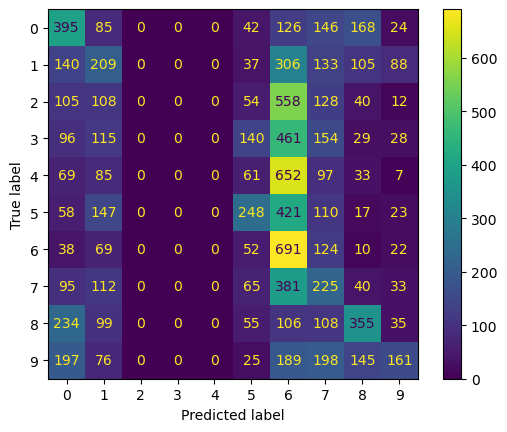

In [33]:
#Decision tree

fig, axes = plt.subplots(figsize=(6, 6))
dtc = DecisionTreeClassifier(max_depth = 3,random_state=seed).fit(X_tr, y_tr)
#Confusion Matrix
y_te_pred = dtc.predict(X_te)
sklearn_cm = confusion_matrix(y_te, y_te_pred)
sklearn_disp = ConfusionMatrixDisplay(confusion_matrix = sklearn_cm)
sklearn_disp.plot()
# Accuracy, Precision, Recall, ROC AUC score
y_te_scores = dtc.predict_proba(X_te)
print('Accuracy: %.5f' % accuracy_score(y_te, y_te_pred))
print('Precision: %.5f' % precision_score(y_te, y_te_pred,average='macro'))
print('Recall: %.5f' % recall_score(y_te, y_te_pred,average='macro'))
print('roc_auc_score: %.5f'% roc_auc_score(y_te,y_te_scores, average='macro',multi_class='ovr'))

#Learning Curve
train_sizes, train_scores, test_scores = learning_curve(estimator=dtc, X=X_tr, y=y_tr,n_jobs=1)
train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)

axes.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Training Accuracy')
axes.plot(train_sizes, test_mean, color='red', marker='+', markersize=5, label='Validation Accuracy')
axes.set_title('Learning Curve for Logistic Regression')
axes.set_xlabel('Training Data Size')
axes.set_ylabel('Accuracy')
axes.legend(loc='lower right')
